In [ ]:
pip install tsfresh

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters, settings
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import itertools
import os
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import dill


from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

CREATING FEATURE FILE

In [ ]:
!rm -r sample_data

from zipfile import ZipFile
filename="/content/drive/My Drive/Bitirme Projesi/Data.zip"
with ZipFile(filename,"r") as zp:
    zp.extractall()
    print("Done") 

In [ ]:
Class = ['TT', 'II', 'MM', 'RR', 'LL', 'TI', 'TM', 'TR', 'TL', 'HC']
Data = pd.DataFrame(columns = ["id", "s1", "s2"])
Target = []

ID = 1
for subject in os.listdir("Data"):
    path = "Data/" + subject
    for mov in os.listdir(path):
        
        movName = (mov.split(".")[0][:-1]).replace("-", "")
        Target.append(Class.index(movName))
        
        movPath = path + "/" + mov
        csv = pd.read_csv(movPath, header=None)
        
        df = pd.DataFrame()
        df["id"] = [ID] * 20000
        df["s1"] = list(csv[0])
        df["s2"] = list(csv[1])
        
        Data = Data.append(df)
        ID += 1

In [ ]:
df_data = extract_features(Data, column_id='id', default_fc_parameters=EfficientFCParameters(), impute_function=impute)

In [ ]:
df_data["Target"] = Target
df_data.to_csv('/content/drive/My Drive/features.csv', index=False)

SELECTING AND SAVING FEATURES

In [ ]:
df_data = pd.read_csv("/content/drive/My Drive/features.csv", index_col=0)

Target = df_data["Target"].tolist()
df_data = df_data.iloc[:,:-1]

In [ ]:
df_data

,s1__abs_energy,s1__absolute_sum_of_changes,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40","s1__agg_autocorrelation__f_agg_""median""__maxlag_40","s1__agg_autocorrelation__f_agg_""var""__maxlag_40","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","s1__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","s1__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","s1__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""min""","s1__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","s1__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","s1__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","s1__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","s1__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","s1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","s1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","s1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","s1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","s1__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","s1__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","s1__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""",...,s2__ratio_beyond_r_sigma__r_6,s2__ratio_beyond_r_sigma__r_7,s2__ratio_value_number_to_time_series_length,s2__skewness,s2__spkt_welch_density__coeff_2,s2__spkt_welch_density__coeff_5,s2__spkt_welch_density__coeff_8,s2__standard_deviation,s2__sum_of_reoccurring_data_points,s2__sum_of_reoccurring_values,s2__sum_values,s2__symmetry_looking__r_0.0,s2__symmetry_looking__r_0.05,s2__symmetry_looking__r_0.1,s2__symmetry_looking__r_0.15000000000000002,s2__symmetry_looking__r_0.2,s2__symmetry_looking__r_0.25,s2__symmetry_looking__r_0.30000000000000004,s2__symmetry_looking__r_0.35000000000000003,s2__symmetry_looking__r_0.4,s2__symmetry_looking__r_0.45,s2__symmetry_looking__r_0.5,s2__symmetry_looking__r_0.55,s2__symmetry_looking__r_0.6000000000000001,s2__symmetry_looking__r_0.65,s2__symmetry_looking__r_0.7000000000000001,s2__symmetry_looking__r_0.75,s2__symmetry_looking__r_0.8,s2__symmetry_looking__r_0.8500000000000001,s2__symmetry_looking__r_0.9,s2__symmetry_looking__r_0.9500000000000001,s2__time_reversal_asymmetry_statistic__lag_1,s2__time_reversal_asymmetry_statistic__lag_2,s2__time_reversal_asymmetry_statistic__lag_3,s2__value_count__value_-1,s2__value_count__value_0,s2__value_count__value_1,s2__variance,s2__variance_larger_than_standard_deviation,s2__variation_coefficient
0,0.008059,1.771991,-0.007446,-0.132530,0.085493,0.000533,0.000032,-0

In [ ]:
col_corr = set() # Set of all the names of deleted columns
corr_matrix = df_data.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= 0.95) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in df_data.columns:
                del df_data[colname] # deleting the column from the df_data

In [ ]:
df_data

,s1__abs_energy,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40","s1__agg_autocorrelation__f_agg_""median""__maxlag_40","s1__agg_autocorrelation__f_agg_""var""__maxlag_40","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","s1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","s1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","s1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","s1__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""",s1__ar_coefficient__coeff_0__k_10,s1__ar_coefficient__coeff_10__k_10,s1__ar_coefficient__coeff_1__k_10,s1__ar_coefficient__coeff_2__k_10,s1__ar_coefficient__coeff_4__k_10,s1__ar_coefficient__coeff_5__k_10,s1__ar_coefficient__coeff_6__k_10,s1__ar_coefficient__coeff_7__k_10,s1__ar_coefficient__coeff_8__k_10,s1__ar_coefficient__coeff_9__k_10,"s1__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","s1__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","s1__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",s1__autocorrelation__lag_0,s1__autocorrelation__lag_1,s1__autocorrelation__lag_7,s1__binned_entropy__max_bins_10,s1__c3__lag_1,"s1__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0","s1__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0",...,s2__range_count__max_1__min_-1,s2__ratio_beyond_r_sigma__r_0.5,s2__ratio_beyond_r_sigma__r_1.5,s2__ratio_beyond_r_sigma__r_10,s2__ratio_beyond_r_sigma__r_2,s2__ratio_beyond_r_sigma__r_2.5,s2__ratio_beyond_r_sigma__r_3,s2__ratio_beyond_r_sigma__r_5,s2__ratio_beyond_r_sigma__r_6,s2__ratio_beyond_r_sigma__r_7,s2__ratio_value_number_to_time_series_length,s2__skewness,s2__sum_of_reoccurring_values,s2__symmetry_looking__r_0.0,s2__symmetry_looking__r_0.05,s2__symmetry_looking__r_0.1,s2__symmetry_looking__r_0.15000000000000002,s2__symmetry_looking__r_0.2,s2__symmetry_looking__r_0.25,s2__symmetry_looking__r_0.30000000000000004,s2__symmetry_looking__r_0.35000000000000003,s2__symmetry_looking__r_0.4,s2__symmetry_looking__r_0.45,s2__symmetry_looking__r_0.5,s2__symmetry_looking__r_0.55,s2__symmetry_looking__r_0.6000000000000001,s2__symmetry_looking__r_0.65,s2__symmetry_looking__r_0.7000000000000001,s2__symmetry_looking__r_0.75,s2__symmetry_looking__r_0.8,s2__symmetry_looking__r_0.8500000000000001,s2__symmetry_looking__r_0.9,s2__symmetry_looking__r_0.9500000000000001,s2__time_reversal_asymmetry_statistic__lag_1,s2__time_reversal_asymmetry_statistic__lag_2,s2__value_count__value_-1,s2__value_count__value_0,s2__value_count__value_1,s2__variance_larger_than_standard_deviation,s2__variation_coefficient
0,0.008059,-0.007446,-0.132530,0.085493,0.000533,0.000032,-0.000474,-0.177575,-0.002369,0.155497,-0.186268,-0.370073,0.337507,-1.778291e-07,-2.170486e-09,1.749613e-07,-1.881389e-10,2.204785e-08,2.486603e-08,4.425192e-12,7.874746e-07,-0.053321,2.658177,-2.521827,0.911949,-0.692465,-0.290930,0.855165,-0.684074,0.276316,0.0,-29.416364,45.0,1.0,0.966111,0.133872,0.976557,-1.229647e-10,1.177177e-06,1.382812e-06,...,20000.0,0.33135,0.05210,0.00165,0.02790,0.01715,0.01295,0.00655,0.00435,0.00345,0.25015,-0.175437,0.093277,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-6.

In [ ]:
features = df_data.columns
Data = list(df_data.values)

X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(Data, Target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Print the name and gini importance of each feature
imp = []
for feature in zip(features, clf.feature_importances_):
    imp.append(feature)

sorted_imp = sorted(imp, key=lambda tup: tup[1])
print(sorted_imp)

[('s1__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 0.0), ('s1__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 0.0), ('s1__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 0.0), ('s1__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 0.0), ('s1__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 0.0), ('s1__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 0.0), ('s1__autocorrelation__lag_0', 0.0), ('s1__c3__lag_1', 0.0), ('s1__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 0.0), ('s1__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 0.0), ('s1__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 0.0), ('s1__fft_coefficient__attr_"imag"__coeff_0', 0.0), ('s1__has_duplicate', 0.0), ('s1__large_standard_deviation__r_0.2', 0.0), ('s1__large_standard_deviation__r_0.25', 0.0), ('s1__large_standard_deviation__r_0.30000000000000004', 0.0), ('s1__large_standard_deviation__r_0.35000000000000003'

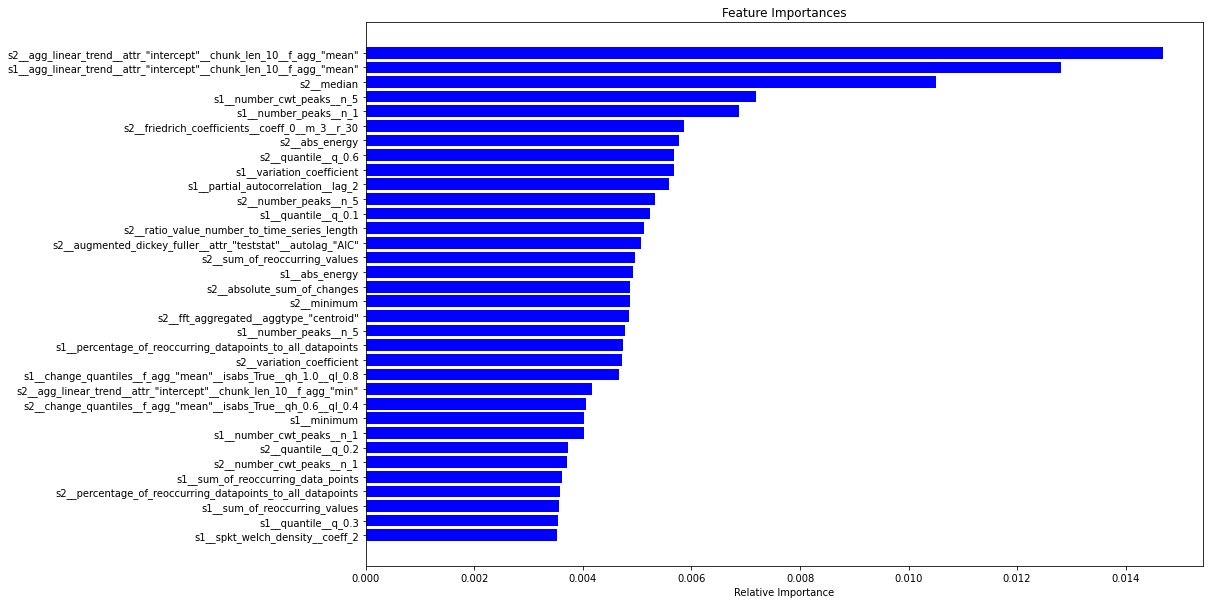

In [1]:
tops = sorted_imp[-34:]  # top 10 features
fname = [top[0] for top in tops]
fvalue = [top[1] for top in tops]

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(tops)), fvalue, color='b', align='center')
plt.yticks(range(len(tops)), fname)
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.003
sfm = SelectFromModel(clf, threshold=0.003)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=-1,
                                                 oob_score=False,


In [ ]:
# Print the names of the most important features
print("Most important feature count:", len(sfm.get_support(indices=True)))
for feature_list_index in sfm.get_support(indices=True):
    print(features[feature_list_index])

Most important feature count: 34
s1__abs_energy
s1__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"
s1__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"
s1__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8
s1__minimum
s1__number_cwt_peaks__n_1
s1__number_cwt_peaks__n_5
s1__number_peaks__n_1
s1__number_peaks__n_5
s1__partial_autocorrelation__lag_2
s1__percentage_of_reoccurring_datapoints_to_all_datapoints
s1__quantile__q_0.1
s1__sum_of_reoccurring_data_points
s1__sum_of_reoccurring_values
s1__variation_coefficient
s2__abs_energy
s2__absolute_sum_of_changes
s2__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"
s2__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"
s2__ar_coefficient__coeff_4__k_10
s2__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"
s2__fft_aggregated__aggtype_"centroid"
s2__fft_coefficient__attr_"abs"__coeff_88
s2__friedrich_coefficients__coeff_0__m_3__r_30
s2__median
s2__minimum
s2__number_peaks__n_5


In [ ]:
with open('/content/drive/My Drive/sfm.obj', 'wb') as f:
    dill.dump(sfm, f)

In [ ]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':["gini", "entropy"],
               'max_features':["auto", "sqrt", "log2"]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_important_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.4min finished


In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = rf_random.best_estimator_.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (112 Features) Model
accuracy_score(y_test, y_important_pred)

0.975

In [ ]:
with open('/content/drive/My Drive/classifier.obj', 'wb') as f:
    dill.dump(rf_random.best_estimator_, f)

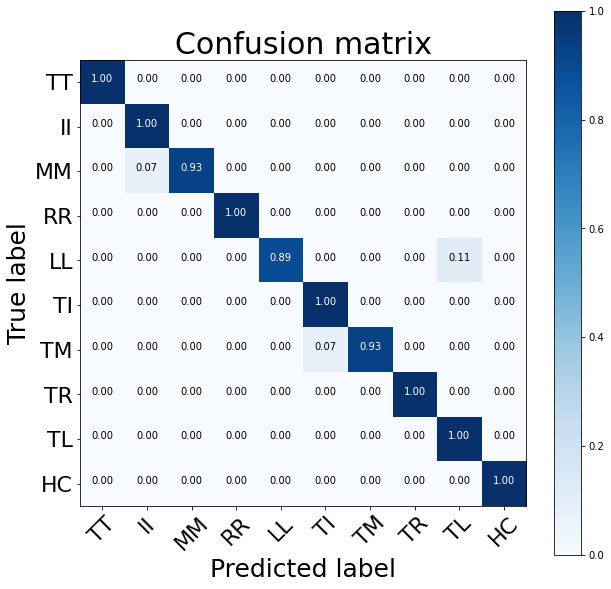

In [ ]:
# creating the confusion matrix
Class = ['TT', 'II', 'MM', 'RR', 'LL', 'TI', 'TM', 'TR', 'TL', 'HC']
cnf_matrix = confusion_matrix(y_test, y_important_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=Class, title="Confusion matrix")
plt.show()# creating the confusion matrix

LOADING MODELS

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Data, Target, test_size=0.2)

sfm_load = dill.load(open("/content/drive/My Drive/sfm.obj","rb"))
X_important_train1 = sfm.transform(X_train1)
X_important_test1 = sfm.transform(X_test1)

model_load = dill.load(open("/content/drive/My Drive/classifier.obj","rb"))

y_important_pred1 = model_load.predict(X_important_test1)
accuracy_score(y_test1, y_important_pred1)

In [ ]:
# creating the confusion matrix
Class = ['TT', 'II', 'MM', 'RR', 'LL', 'TI', 'TM', 'TR', 'TL', 'HC']
cnf_matrix = confusion_matrix(y_test1, y_important_pred1)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=Class, title="Confusion matrix")
plt.show()# creating the confusion matrix